In [1]:
#Libraries installation
!pip install pandas
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib

In [0]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
test_ident = pd.read_csv('/content/drive/My Drive/PythonData/KaggleComp_FraudDetection/test_identity.csv', low_memory=False)
test_trans = pd.read_csv('/content/drive/My Drive/PythonData/KaggleComp_FraudDetection/test_transaction.csv', low_memory=False)

train_ident = pd.read_csv('/content/drive/My Drive/PythonData/KaggleComp_FraudDetection/train_identity.csv', low_memory=False)
train_trans = pd.read_csv('/content/drive/My Drive/PythonData/KaggleComp_FraudDetection/train_transaction.csv', low_memory=False)

#df = df.sample(frac=1).reset_index(drop=True)

In [0]:
 #Function to reduce the sie of the data, changing data from float64->float32, etc.
  def reduce_mem_usage(df):
    numv = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2 
    for col in df.columns:
        vt = df[col].dtypes
        if vt in numv:
            max_c = df[col].max()
            min_c = df[col].min()
            if str(vt)[:3] == 'int':
                if min_c > np.iinfo(np.int8).min and max_c < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif min_c > np.iinfo(np.int16).min and max_c < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif min_c > np.iinfo(np.int32).min and max_c < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif min_c > np.iinfo(np.int64).min and max_c < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if min_c > np.finfo(np.float16).min and max_c < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif min_c > np.finfo(np.float32).min and max_c < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                elif min_c > np.finfo(np.float64).min and max_c < np.finfo(np.float64).max:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
#Reduce size
test_ident = reduce_mem_usage(test_ident)
test_trans = reduce_mem_usage(test_trans)

train_ident = reduce_mem_usage(train_ident)
train_trans = reduce_mem_usage(train_trans)

Mem. usage decreased to 25.44 Mb (42.7% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)


In [7]:
#Join dataset using TransactionID as index
dftrain = pd.merge(train_trans, train_ident, on='TransactionID', how='left')
print(dftrain.shape)

dfttest = pd.merge(test_trans, test_ident, on='TransactionID', how='left')
print(dftrain.shape)

del train_ident, train_trans, test_trans, test_ident

(590540, 434)
(590540, 434)


In [0]:
#Creating an dataframe with null values and percentage
miss_data = pd.isnull(dftrain).sum().sort_values(ascending=False)
miss_per = (miss_data/len(dftrain))*100
missing_data = pd.concat(objs = [miss_data, miss_per], keys = ['Columns','Missing values percentage'], axis = 1)

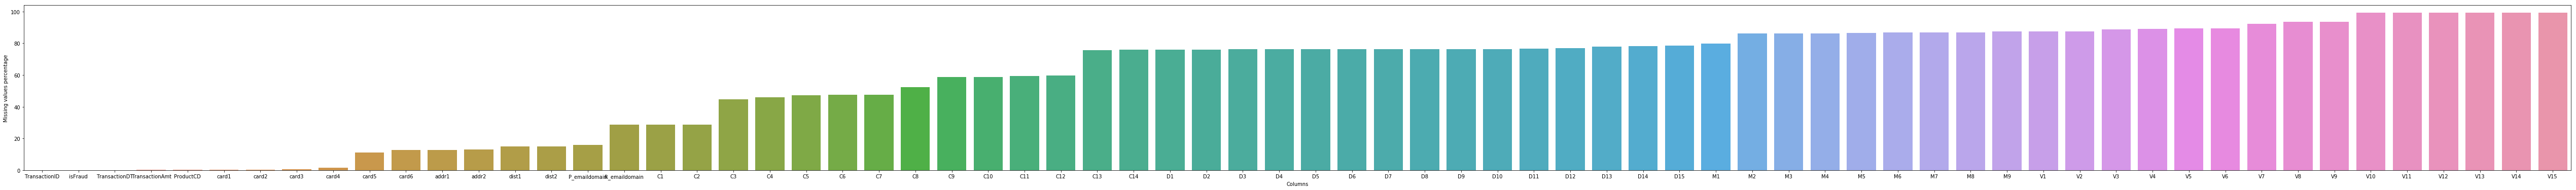

In [9]:
plt.figure(figsize=(90,6))
p = sns.barplot(x = 'Columns', y = 'Missing values percentage', data = missing_data)
p.set_xticklabels(list(dftrain.columns))
p

In [10]:
#Delete the columns with less than 90% of the data
nullcol = [col for col in dftrain.columns if dftrain[col].isnull().sum()/dftrain.shape[0] >= 0.9]
print("More than 90% null: " + str(len(nullcol)))
print(nullcol)
print("")
print("Shape before: " + str(dftrain.shape))
dftrain = dftrain.drop(nullcol, axis=1)
print("Shape after: " + str(dftrain.shape))

More than 90% null: 12
['dist2', 'D7', 'id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']

Shape before: (590540, 434)
Shape after: (590540, 422)


In [11]:
#Check nullcol for isFraud == 1
print("Fraudulents " + str(len(dftrain.loc[dftrain['isFraud']==1])))
print("Non Fraudulents " + str(len(dftrain.loc[dftrain['isFraud']==0])))

#nullcolf = [col for col in dftrain.columns if dftrain[col].isnull().sum()/dftrain.shape[0] >= 0.9 and dftrain.loc[dftrain['isFraud']==1]]
#print(nullcolf)

Fraudulents 20663
Non Fraudulents 569877


In [12]:
#Columns that have 0 missing percent
print(missing_data.loc[missing_data['Missing values percentage']==0].index)


Index(['card1', 'ProductCD', 'TransactionAmt', 'TransactionDT', 'isFraud',
       'C9', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C10', 'C11',
       'C12', 'C13', 'C14', 'TransactionID'],
      dtype='object')


In [13]:
#Standarize the non númeric values
numericCols = dftrain._get_numeric_data().columns
non_numericCols = list(set(dftrain.columns) - set(numericCols))
print(non_numericCols)
print(numericCols)
dftrain[non_numericCols] = dftrain[non_numericCols].replace({np.nan:'missing'})
dftrain[numericCols] = dftrain[numericCols].replace({np.nan: 999})



['DeviceInfo', 'P_emaildomain', 'M5', 'M7', 'id_30', 'M8', 'M6', 'M2', 'DeviceType', 'M1', 'R_emaildomain', 'id_29', 'id_12', 'id_16', 'id_37', 'id_38', 'id_31', 'id_35', 'M9', 'ProductCD', 'card6', 'id_28', 'card4', 'id_34', 'id_33', 'M4', 'id_15', 'M3', 'id_36']
Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'id_06', 'id_09', 'id_10', 'id_11', 'id_13', 'id_14', 'id_17', 'id_19',
       'id_20', 'id_32'],
      dtype='object', length=393)


In [14]:
print(np.unique(dftrain['P_emaildomain']))
print(np.unique(dftrain['M6']))
print(np.unique(dftrain['ProductCD']))
print(np.unique(dftrain['id_37']))
print(np.unique(dftrain['id_35']))
print(np.unique(dftrain['card6']))
print(np.unique(dftrain['M2']))
print(np.unique(dftrain['id_15']))
print(np.unique(dftrain['DeviceInfo']))
print(np.unique(dftrain['id_28']))
print(np.unique(dftrain['id_16']))
print(np.unique(dftrain['M8']))
print(np.unique(dftrain['M9']))
print(np.unique(dftrain['DeviceType']))
#print(np.unique(dftrain['id_33']))
print(np.unique(dftrain['id_31']))
print(np.unique(dftrain['M1']))
print(np.unique(dftrain['card4']))
print(np.unique(dftrain['R_emaildomain']))
print(np.unique(dftrain['M7']))
#print(np.unique(dftrain['id_30']))
#print(np.unique(dftrain['id_34']))
print(np.unique(dftrain['M4']))
print(np.unique(dftrain['id_12']))
print(np.unique(dftrain['id_29']))
print(np.unique(dftrain['id_36']))
print(np.unique(dftrain['M3']))
print(np.unique(dftrain['id_38']))
print(np.unique(dftrain['M5']))

['aim.com' 'anonymous.com' 'aol.com' 'att.net' 'bellsouth.net'
 'cableone.net' 'centurylink.net' 'cfl.rr.com' 'charter.net' 'comcast.net'
 'cox.net' 'earthlink.net' 'embarqmail.com' 'frontier.com'
 'frontiernet.net' 'gmail' 'gmail.com' 'gmx.de' 'hotmail.co.uk'
 'hotmail.com' 'hotmail.de' 'hotmail.es' 'hotmail.fr' 'icloud.com'
 'juno.com' 'live.com' 'live.com.mx' 'live.fr' 'mac.com' 'mail.com'
 'me.com' 'missing' 'msn.com' 'netzero.com' 'netzero.net' 'optonline.net'
 'outlook.com' 'outlook.es' 'prodigy.net.mx' 'protonmail.com' 'ptd.net'
 'q.com' 'roadrunner.com' 'rocketmail.com' 'sbcglobal.net' 'sc.rr.com'
 'servicios-ta.com' 'suddenlink.net' 'twc.com' 'verizon.net' 'web.de'
 'windstream.net' 'yahoo.co.jp' 'yahoo.co.uk' 'yahoo.com' 'yahoo.com.mx'
 'yahoo.de' 'yahoo.es' 'yahoo.fr' 'ymail.com']
['F' 'T' 'missing']
['C' 'H' 'R' 'S' 'W']
['F' 'T' 'missing']
['F' 'T' 'missing']
['charge card' 'credit' 'debit' 'debit or credit' 'missing']
['F' 'T' 'missing']
['Found' 'New' 'Unknown' 'missing'

In [0]:
#Irrelevant cols selected for their irrelevent info
IrrCol = ['id_33']
dftrain = dftrain.drop(IrrCol,axis=1)


The size of is dftrain before (590540, 421)
The size of non fraud(20663, 421)
The size of is fraud(20663, 421)
The size of non fraud(41326, 421)
The size of is dftrain after(41326, 421)


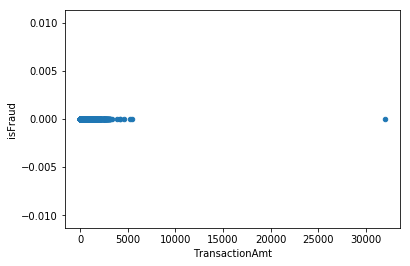

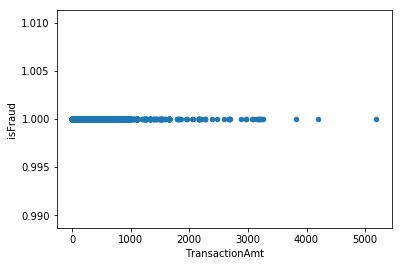

In [16]:
#Reduce size of the dataset (not enough RAM)

print('The size of is dftrain before ' + str(dftrain.shape))
      
dftrain_isF = dftrain[dftrain['isFraud']==1]
dftrain_noF = dftrain[dftrain['isFraud']==0].sample(n=len(dftrain_isF))


dftrain_noF.plot(x = 'TransactionAmt', y=1, kind = 'scatter')
dftrain_isF.plot(x = 'TransactionAmt', y=1, kind = 'scatter')

print("The size of non fraud" + str(dftrain_noF.shape))
print("The size of is fraud" + str(dftrain_isF.shape))

del dftrain

dftrain = dftrain_noF.append(dftrain_isF)
print("The size of non fraud" + str(dftrain.shape))
dftrain = dftrain.sample(frac=1).reset_index(drop=True)

del dftrain_noF, dftrain_isF
      
print("The size of is dftrain after" + str(dftrain.shape))



# Machine Learning

In [0]:
dftrain = dftrain.replace(np.inf,999)
#dftest = dftest.replace(np.inf,999)

dftrain['TransactionAmt'] = np.log1p(dftrain['TransactionAmt'])
#dftest['TransactionAmt'] = np.log1p(dftest['TransactionAmt'])



In [0]:
y_train = dftrain['isFraud']
dftrain = pd.get_dummies(dftrain)
X_train = dftrain.drop('isFraud', axis=1)
X_train = X_train.fillna(0)

del dftrain

In [0]:
q = 0
scaler = MinMaxScaler()
for col in X_train.columns:
    a = np.array(X_train[col])
    a = a.reshape(-1,1)
    X_train[col] = scaler.fit_transform(a)
    if q >= 100:
        break
    else:
        q+=1
        continue
del a

In [20]:
#Export datasets prepared as vector, to avoid reprocessing
vectorizer = CountVectorizer()
from sklearn.externals import joblib
joblib.dump(X_train, '/content/drive/My Drive/PythonData/KaggleComp_FraudDetection/dataset.joblib')
joblib.dump(y_train, '/content/drive/My Drive/PythonData/KaggleComp_FraudDetection/datasety.joblib')
del X_train, y_train

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
#Import datasets
x_train = joblib.load('/content/drive/My Drive/PythonData/KaggleComp_FraudDetection/dataset.joblib')
y_train = joblib.load('/content/drive/My Drive/PythonData/KaggleComp_FraudDetection/datasety.joblib')


In [22]:
lr = LogisticRegression(solver="liblinear", random_state=42)
lr.fit(x_train, y_train[:np.shape(x_train)[0]])


score = cross_val_score(lr, x_train, y_train[:np.shape(x_train)[0]], cv=3, verbose=3)
score.mean()

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.5s remaining:    0.0s


[CV] .................................... , score=0.714, total=  54.5s
[CV]  ................................................................


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV] .................................... , score=0.713, total=  43.3s
[CV]  ................................................................
[CV] .................................... , score=0.707, total=  47.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.4min finished


0.7111985395456021

In [24]:
d = {'col1': [1, 2], 'col2': [3, 4]}
e = {'col1': [3, 4], 'col2': [5, 6]}
dd = pd.DataFrame(data=d)
ee = pd.DataFrame(data=e)
dd
ee

dd.append(ee)
print("h " + str(dd.shape))

dd = dd.append(ee)
print("h " + str(dd.shape))

h (2, 2)
h (4, 2)
